# spectrogram variational auto encoder

- auto encoder를 학습하는 모델.
- healthy 데이터를 fold에 맞게 학습해본다.

05.10

- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

p = os.path.abspath('D:/project/voice_pathology_ai/model') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
import torchaudio.transforms as T

# healthy 데이터 불러오기

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

In [3]:
import pickle
#load
fold_list=[]
for fold in range(5):
    with open("D:/project/voice_pathology_ai/model/varauto/spectro/alldata/fold{}/healthy/healthy-stft.pickle".format(fold+1),"rb") as fr:
        healthy_dict = pickle.load(fr)
        fold_list.append(healthy_dict)

In [4]:
fold_list[1]

{'69-phrase.wav': array([[-1.27115503e-01+0.0000000e+00j, -2.11111009e-01+0.0000000e+00j,
         -2.80820459e-01+0.0000000e+00j, ...,
         -7.23311961e-01+0.0000000e+00j, -4.84250993e-01+0.0000000e+00j,
         -1.61365151e-01+0.0000000e+00j],
        [ 8.14438015e-02-6.9228925e-02j,  9.49055701e-02-1.0198457e-02j,
          1.61433160e-01-5.9664819e-02j, ...,
          4.51967597e-01+4.7064189e-02j,  2.43290409e-01+1.8873915e-01j,
          4.02823351e-02+1.2396420e-01j],
        [-2.64694057e-02+6.2816732e-02j,  2.88793594e-02-4.2999286e-02j,
         -1.54150184e-02+6.1323732e-02j, ...,
         -1.14515178e-01-3.5541318e-02j,  9.87119414e-03-3.3564482e-02j,
          5.69041371e-02-5.0900735e-02j],
        ...,
        [ 1.37283087e-05-9.9613599e-06j, -4.21381947e-06-1.8257204e-05j,
          2.49039258e-05+3.5866004e-05j, ...,
          7.68098062e-07-1.0340677e-05j,  4.34503854e-05-4.8729402e-05j,
         -3.49122711e-04+6.0087914e-04j],
        [-2.20413185e-05+2.2225008

In [5]:
len(fold_list)

5

In [6]:
X_train_list=[]
for i in range(5):
    X_train_list.append( list(fold_list[i].keys()) )

In [7]:
print('1폴드당 데이터 수 : ',len(X_train_list[0]))

1폴드당 데이터 수 :  406


학습 데이터, 전부 이용해서, 200개의 sample 추출.

# 데이터 정의


0503 여기부터 수정.

In [8]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,data_num,transform=None,):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.transform = transform
        
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        """
        stft = fold_list[self.data_num][self.path_list[idx]]
        
        #padding
        length=300
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        stft = pad2d(stft, length)
        stft=stft[:128,:]# 224 x 300 으로 사이즈 조절
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        
        if self.transform:
            log_spectrogram = self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            #log_spectrogram = log_spectrogram.squeeze(dim=0)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram,
    
    

# 데이터 로더

In [9]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [10]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
#transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.




# 데이터 확인

X_train :  torch.Size([4, 1, 128, 300]) type: torch.FloatTensor


Text(0.5, 1.0, 'Spectrogram (dB)')

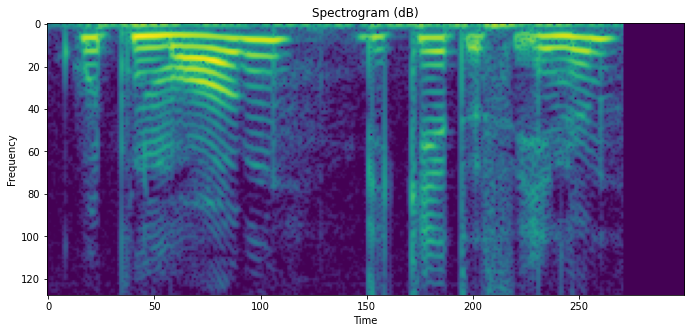

In [11]:
# 4. 데이터 확인하기
for (X_train,) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    break

plt.figure(figsize=(15,5))
plt.imshow(X_train[0].view(128,300,1).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# variational auto encoder

https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71

In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [18]:

input_data=torch.ones((32,1,128,300))
conv1=nn.Conv2d(1, ,3,2)
conv2=nn.Conv2d(1,10,3,2)
conv1(input_data).size()



torch.Size([32, 10, 63, 149])

In [12]:
# 모델 

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2,h_dim3,z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.encoder_cnn1 = nn.Conv2d(1,10,3)
        self.encoder_cnn2 = nn.Conv2d(10,10,3)
        
        
        
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        
        self.fc41 = nn.Linear(h_dim3, z_dim)
        self.fc42 = nn.Linear(h_dim3, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim3)
        self.encoder_cnn1 = nn.Conv2d(1,10,3)
        self.encoder_cnn2 = nn.Conv2d(10,10,3)
        
        
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        
        return self.fc41(h), self.fc42(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var) # e^(0.5*log_var)
        eps = torch.randn_like(std) # std사이즈와 같은 정규분포 랜덤 z값 생성. 
        
        
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        h = F.relu(self.fc6(h))
        
        
        return F.sigmoid(self.fc7(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 128*300))
        z = self.sampling(mu, log_var) 
        # 왜 encoder 결과가 mu와 log_var 인지?
        # 해당 이미지가 mu 에 위치하고, var만큼 퍼져있는 지역에 있다는 의미.
        # z라는 랜덤변수를 추출해서, decoder로.
        
        return self.decoder(z), mu, log_var

# build model    
def model_initialize():
    vae = VAE(x_dim=300,y_dim=128, h_dim1= 128*128,h_dim2=64*64, h_dim3=256, z_dim=2)
    vae = vae.cuda()
    return vae

#vae=model_initialize()


In [13]:
#vae

In [14]:

#optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 128*300), reduction='sum') #합이 같은지를 비교
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [15]:

def train(Epoch,model,train_loader,optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                Epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(Epoch, train_loss / len(train_loader.dataset)))

In [16]:
#데이터 로더 제작 함수


def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    return train_loader



In [17]:
#10. 학습 및 평가.
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = 'D:/project/voice_pathology_ai/model/checkpoint'+str(data_ind)+'_fold_VarAuto_mlp.pt'
    print(check_path)
    train_loader = load_data(data_ind-1)
    
    model=model_initialize()
    optimizer = torch.optim.Adam(model.parameters())
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train(Epoch,model,train_loader,optimizer)
    
    torch.save(model.state_dict(), check_path)
    

D:/project/voice_pathology_ai/model/checkpoint1_fold_VarAuto_mlp.pt
[1 교차검증] 학습 시작
 ----- 


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: CUDA out of memory. Tried to allocate 2.34 GiB (GPU 0; 24.00 GiB total capacity; 20.78 GiB already allocated; 910.05 MiB free; 20.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Model 결과 확인

In [29]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 93.7644 |	 valid ACC: 81.7610 
[2 교차검증] train ACC : 96.4203 |	 valid ACC: 84.9057 
[3 교차검증] train ACC : 93.7067 |	 valid ACC: 84.9057 
[4 교차검증] train ACC : 94.6943 |	 valid ACC: 83.0189 
[5 교차검증] train ACC : 91.8108 |	 valid ACC: 78.9308 
평균 검증 정확도 82.70440251572327 %


# Model Test

- test set
- confusion matrix

In [30]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [31]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_alldata_aug.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 82.4121% 
Precision (pathology 예측한 것중 맞는 것) : 0.8941
recall (실제 pathology 중  예측이 맞는 것) : 0.8413
f score : 0.8038 
[[228  43]
 [ 27 100]]
-----
2번 모델
Accuracy : 80.6533% 
Precision (pathology 예측한 것중 맞는 것) : 0.8880
recall (실제 pathology 중  예측이 맞는 것) : 0.8192
f score : 0.7861 
[[222  49]
 [ 28  99]]
-----
3번 모델
Accuracy : 80.9045% 
Precision (pathology 예측한 것중 맞는 것) : 0.8421
recall (실제 pathology 중  예측이 맞는 것) : 0.8856
f score : 0.7733 
[[240  31]
 [ 45  82]]
-----
4번 모델
Accuracy : 83.4171% 
Precision (pathology 예측한 것중 맞는 것) : 0.8727
recall (실제 pathology 중  예측이 맞는 것) : 0.8856
f score : 0.8076 
[[240  31]
 [ 35  92]]
-----
5번 모델
Accuracy : 80.4020% 
Precision (pathology 예측한 것중 맞는 것) : 0.8410
recall (실제 pathology 중  예측이 맞는 것) : 0.8782
f score : 0.7684 
[[238  33]
 [ 45  82]]
-----
평균 acc : 0.8156
평균 f1score : 0.7879


## validation set  답 정리
- validation set 새로 정의. path 가져오기 위해

In [29]:
#confusion matrix 계산
#test set 계산.
def valid_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers
            

In [24]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 validation set을 평가한다

# weak classifier를 위해서 추가했다.


from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
all_name_list = []
all_res_list = []
all_answer_list = []

for data_ind in range(1,6):
    res = []
    
    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_base.pt'
    model.load_state_dict(torch.load(check_path))
    _,validation_loader = load_data(data_ind-1)
    
    predictions,answers = valid_evaluate(model, validation_loader)
    
    predictions = [ dat.cpu().numpy() for dat in predictions]
    answers = [ dat.cpu().numpy() for dat in answers]
    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))






1번 모델
Accuracy : 83.9590% 
Precision (pathology 예측한 것중 맞는 것) : 0.8871
recall (실제 pathology 중  예측이 맞는 것) : 0.8639
f score : 0.8252 
[[165  26]
 [ 21  81]]
-----
2번 모델
Accuracy : 83.2192% 
Precision (pathology 예측한 것중 맞는 것) : 0.8413
recall (실제 pathology 중  예측이 맞는 것) : 0.9162
f score : 0.8062 
[[175  16]
 [ 33  68]]
-----
3번 모델
Accuracy : 82.8767% 
Precision (pathology 예측한 것중 맞는 것) : 0.8543
recall (실제 pathology 중  예측이 맞는 것) : 0.8901
f score : 0.8070 
[[170  21]
 [ 29  72]]
-----
4번 모델
Accuracy : 82.5342% 
Precision (pathology 예측한 것중 맞는 것) : 0.8465
recall (실제 pathology 중  예측이 맞는 것) : 0.8953
f score : 0.8016 
[[171  20]
 [ 31  70]]
-----
5번 모델
Accuracy : 80.4795% 
Precision (pathology 예측한 것중 맞는 것) : 0.8935
recall (실제 pathology 중  예측이 맞는 것) : 0.7947
f score : 0.7939 
[[151  39]
 [ 18  84]]
-----
평균 acc : 0.8261
평균 f1score : 0.8068


# 기타

In [32]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [33]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [34]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])